# EDA (Explanatory Data Analysis)

En este archivo se ha realizado el análisis de la base de datos utilizada para el proyecto, investigando las variables, su tipología, el balance del conjunto y los valores de las variables.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold


In [2]:
train_identity = pd.read_csv('/kaggle/input/ieee-data/train_identity.csv')
train_transaction = pd.read_csv('/kaggle/input/ieee-data/train_transaction.csv')

In [3]:
print("Dimensiones de train_transaction:", train_transaction.shape)
print("Dimensiones de train_identity:", train_identity.shape)

df_train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
print("\nDimensiones después de unir df_train:", df_train.shape)

if 'id_01' in df_train.columns:
    identidad_no_nula = df_train['id_01'].notna().sum()
    print(f"Transacciones con información de identidad: {identidad_no_nula} ({identidad_no_nula/len(df_train):.2%})")

Dimensiones de train_transaction: (590540, 394)
Dimensiones de train_identity: (144233, 41)

Dimensiones después de unir df_train: (590540, 434)
Transacciones con información de identidad: 144233 (24.42%)


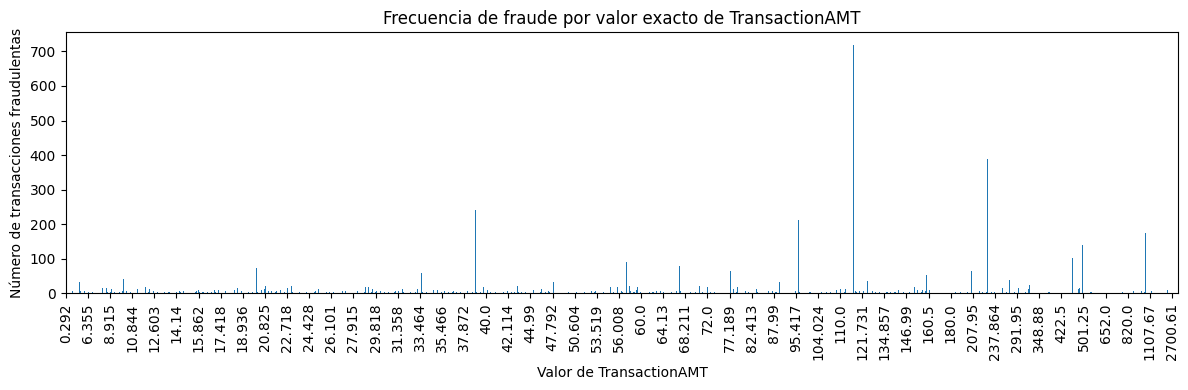

In [4]:
fraude_por_valor = (
    df_train[df_train['isFraud']==1]
    .groupby('TransactionAmt')
    .size()
    .sort_index()               
)

plt.figure(figsize=(12,4))
fraude_por_valor.plot(kind='bar')

plt.xlabel('Valor de TransactionAMT')
plt.ylabel('Número de transacciones fraudulentas')
plt.title('Frecuencia de fraude por valor exacto de TransactionAMT')

ticks = range(0, len(fraude_por_valor), 50)
plt.xticks(ticks, fraude_por_valor.index[ticks], rotation=90)

plt.tight_layout()
plt.show()


In [5]:
#Separación entre columnas normales y la target 
y= df_train['isFraud']
X= df_train.drop(columns=['isFraud'])

skf = StratifiedKFold(n_splits=5, shuffle= True, random_state=42)
for fold, (train_idx,val_idx) in enumerate(skf.split(X,y)):
    X_train,X_val= X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


Analizando valores faltantes...
Columnas con más valores faltantes (train):
id_24    99.199250
id_25    99.132574
id_07    99.129187
id_08    99.129187
id_21    99.128552
id_26    99.127493
id_27    99.126435
id_23    99.126435
id_22    99.126435
dist2    93.637603
D7       93.418735
id_18    92.365674
D13      89.521667
D14      89.475311
D12      89.045408
dtype: float64
Gráfico de valores faltantes guardado como 'missing_values.png'

Columnas con más valores faltantes (test):
id_24    99.183798
id_25    99.124530
id_07    99.118603
id_26    99.118603
id_08    99.118603
id_27    99.117757
id_23    99.117757
id_22    99.117757
id_21    99.117757
dist2    93.591459
D7       93.374708
id_18    92.340908
D13      89.459647
D14      89.446100
D12      89.023606
dtype: float64
La nueva dimension del dataset de train es :
433

Columnas con más del 80% de valores nulos (train): 74
['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_27', 'id_23', 'id_22', 'dist2', 'D7', 'id_18', 'D13'

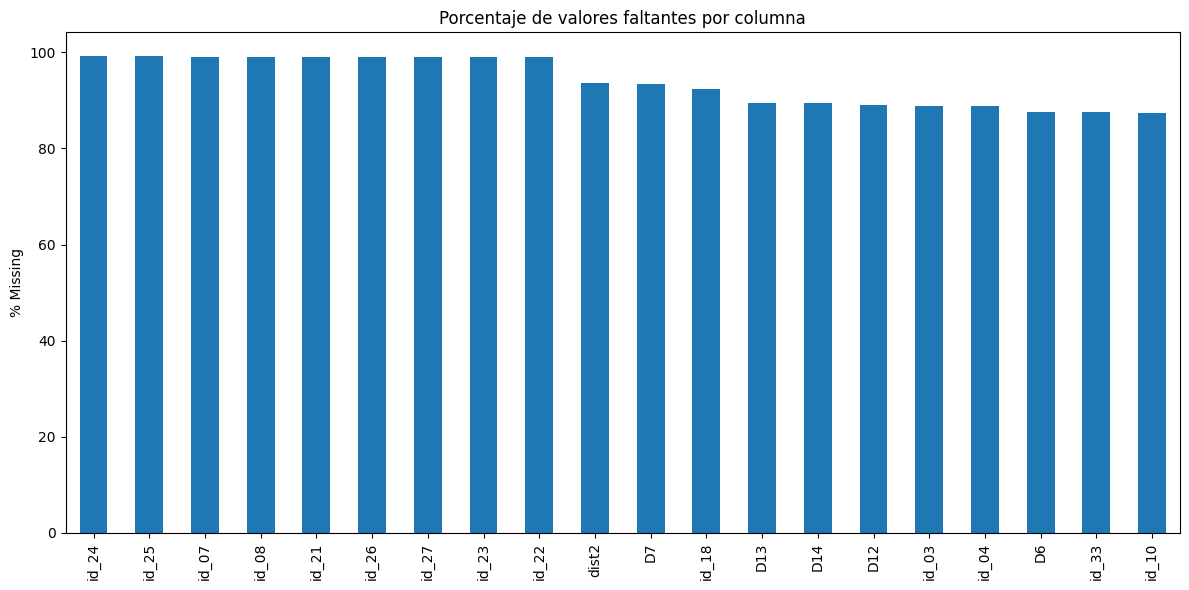

In [6]:
# Calcular porcentaje de valores faltantes por columna
print("\nAnalizando valores faltantes...")
missing_train = (X_train.isnull().sum() / len(X_train)) * 100
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
print(f"Columnas con más valores faltantes (train):")
print(missing_train.head(15))

# Visualizar valores faltantes 
plt.figure(figsize=(12, 6))
missing_train[:20].plot(kind='bar')
plt.title('Porcentaje de valores faltantes por columna')
plt.ylabel('% Missing')
plt.tight_layout()
plt.savefig('missing_values.png')
print("Gráfico de valores faltantes guardado como 'missing_values.png'")

missing_test = (X_val.isnull().sum() / len(X_val)) * 100
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)
print(f"\nColumnas con más valores faltantes (test):")
print(missing_test.head(15))

#Eliminamos las columnas que no contengan ningun valor, solo son nulas en todas las filas 
X_train = X_train.replace({None: np.nan})
columnas_vacias = X_train.columns[X_train.isna().all()].tolist()
X_train = X_train.drop(columns=columnas_vacias)
print( "La nueva dimension del dataset de train es :")
print (X_train.shape[1])


cols_to_drop = missing_train[missing_train > 80].index.tolist()
print(f"\nColumnas con más del 80% de valores nulos (train): {len(cols_to_drop)}")
print(cols_to_drop)

# Eliminar esas columnas tanto en train como en val
print("\nEliminando columnas con más del 80% de valores nulos...")
X_train = X_train.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop)

print(f"Nuevas dimensiones después de eliminar columnas con muchos nulos:")
print(f"Train: {X_train.shape}")
print(f"Test: {X_val.shape}")

In [7]:
# Identificar columnas numéricas y categóricas
#Tal y como se indica en la descripción de la base de datos las columas categóricas son las siguientes:
#ProductCD, card1card6, addr1, addr2, P_emaildomain,R_emaildomain, M1M9,DeviceType,DeviceInfo, id_12id_38 
categoricas_obligatorias = ['card1','card2','card3','card4','card5', 'card6', 'addr1','addr2']
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in categoricas_obligatorias]
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
for col in categoricas_obligatorias:
    if col not in categorical_cols:
        categorical_cols.append(col)
        
exclude_cols = ['isFraud', 'TransactionID']
numeric_cols_for_processing = [col for col in numeric_cols if col not in exclude_cols]

print(f"Columnas numéricas: {len(numeric_cols)}")
print(numeric_cols)
print(f"Columnas categóricas: {len(categorical_cols)}")
print(categorical_cols)



Columnas numéricas: 327
['TransactionID', 'TransactionDT', 'TransactionAmt', 'dist1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V

In [8]:
def create_categorical_summary(df, categorical_cols):
    # Create a dictionary to store results
    cat_summary = []
    
    for col in categorical_cols:
        unique_values = df[col].unique()
        # If more than 7 values, show only first 7
        if len(unique_values) > 7:
            values_str = ", ".join(str(x) for x in unique_values[:7]) + ", ..."
        else:
            values_str = ", ".join(str(x) for x in unique_values)
            
        cat_summary.append({
            'Variable': col,
            'Número de valores únicos': len(unique_values),
            'Valores': values_str,
            'Valores nulos (%)': (df[col].isnull().sum() / len(df)) * 100
        })
    
    # Convert to DataFrame
    summary_df = pd.DataFrame(cat_summary)
    
    # Export to Excel
    excel_path = 'categorical_variables_summary.xlsx'
    summary_df.to_excel(excel_path, index=False, sheet_name='Resumen Variables')
    
    print(f"Resumen exportado a: {excel_path}")
    return summary_df

# Crear y exportar el resumen
summary_table = create_categorical_summary(X_train, categorical_cols)

Resumen exportado a: categorical_variables_summary.xlsx


In [9]:
for col in X_train.columns:
    print(f"Columna: {col}")
    print(X_train[col].unique())
    print("-" * 50)


Columna: TransactionID
[2987000 2987001 2987002 ... 3577537 3577538 3577539]
--------------------------------------------------
Columna: TransactionDT
[   86400    86401    86469 ... 15811079 15811088 15811131]
--------------------------------------------------
Columna: TransactionAmt
[  68.5    29.     59.   ...  557.54 1659.95  400.78]
--------------------------------------------------
Columna: ProductCD
['W' 'H' 'C' 'S' 'R']
--------------------------------------------------
Columna: card1
[13926  2755  4663 ...  2274  8145 18038]
--------------------------------------------------
Columna: card2
[ nan 404. 490. 567. 514. 555. 360. 100. 111. 352. 375. 418. 303. 314.
 543. 321. 361. 583. 399. 569. 453. 417. 545. 266. 114. 481. 547. 343.
 285. 562. 302. 264. 383. 500. 170. 396. 103. 206. 476. 199. 423. 446.
 492. 523. 440. 528. 161. 535. 117. 455. 325. 158. 354. 558. 268. 122.
 269. 512. 174. 215. 265. 388. 408. 309. 415. 437. 104. 225. 101. 586.
 191. 491. 369. 322. 494. 532. 313. 474

In [10]:
print(df_train['card1'].unique())

[13926  2755  4663 ... 13166  8767 18038]


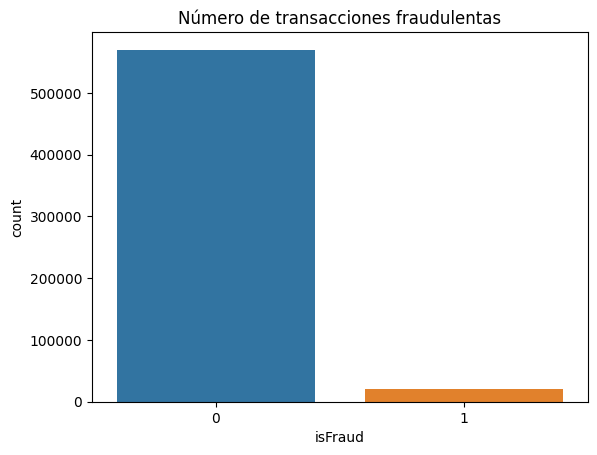


Distribución de la variable objetivo:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


In [11]:
df_fraud = X_train.loc[df_train['isFraud']==1]
df_no_fraud = X_train.loc[df_train['isFraud'] == 0]
sns.countplot(x="isFraud",data=df_train)
plt.title("Número de transacciones fraudulentas")
plt.show()
if 'isFraud' in df_train.columns:
    print("\nDistribución de la variable objetivo:")
    print(df_train['isFraud'].value_counts(normalize=True))

In [12]:
# Imputar valores faltantes para columnas numéricas
print("Imputando valores faltantes en columnas numéricas")
for col in numeric_cols_for_processing:
    if X_train[col].isnull().sum() > 0:
        # Para columnas con cantidades monetarias, usar 0
        if 'Amt' in col or 'amount' in col or 'balance' in col or 'media' in col or 'std' in col:
            X_train[col]= X_train[col].fillna(0)
            X_val[col]= X_val[col].fillna(0)
            print(f"  {col}: Imputado con 0 (columna monetaria)")
        # Para otras columnas numéricas, usar mediana
        else:
            median_value = X_train[col].median()
            X_train[col]= X_train[col].fillna(median_value)
            X_val[col] =X_val[col].fillna(median_value)
            print(f"  {col}: Imputado con mediana ({median_value})")

Imputando valores faltantes en columnas numéricas
  dist1: Imputado con mediana (8.0)
  D1: Imputado con mediana (3.0)
  D2: Imputado con mediana (97.0)
  D3: Imputado con mediana (8.0)
  D4: Imputado con mediana (26.0)
  D5: Imputado con mediana (10.0)
  D10: Imputado con mediana (15.0)
  D11: Imputado con mediana (43.0)
  D15: Imputado con mediana (52.0)
  V1: Imputado con mediana (1.0)
  V2: Imputado con mediana (1.0)
  V3: Imputado con mediana (1.0)
  V4: Imputado con mediana (1.0)
  V5: Imputado con mediana (1.0)
  V6: Imputado con mediana (1.0)
  V7: Imputado con mediana (1.0)
  V8: Imputado con mediana (1.0)
  V9: Imputado con mediana (1.0)
  V10: Imputado con mediana (0.0)
  V11: Imputado con mediana (0.0)
  V12: Imputado con mediana (1.0)
  V13: Imputado con mediana (1.0)
  V14: Imputado con mediana (1.0)
  V15: Imputado con mediana (0.0)
  V16: Imputado con mediana (0.0)
  V17: Imputado con mediana (0.0)
  V18: Imputado con mediana (0.0)
  V19: Imputado con mediana (1.0)
  V2

In [13]:
# Imputar valores faltantes para columnas categóricas
print("\nImputando valores faltantes en columnas categóricas...")
for col in categorical_cols:
    if X_train[col].isnull().sum() > 0:
        # Para dominios de email o información de identidad, usar 'Unknown'
        if 'email' in col.lower() or 'id_' in col.lower() or 'device' in col.lower():
            X_train[col].fillna('Unknown', inplace=True)
            X_val[col].fillna('Unknown', inplace=True)
            print(f"  {col}: Imputado con 'Unknown'")
        # Para otras columnas categóricas, usar el valor más frecuente
        else:
            most_common = X_train[col].mode()[0]
            X_train[col].fillna(most_common, inplace=True)
            X_val[col].fillna(most_common, inplace=True)
            print(f"  {col}: Imputado con valor más común ({most_common})")


Imputando valores faltantes en columnas categóricas...
  card4: Imputado con valor más común (visa)
  card6: Imputado con valor más común (debit)


/tmp/ipykernel_33/3056211578.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(most_common, inplace=True)
/tmp/ipykernel_33/3056211578.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

  P_emaildomain: Imputado con 'Unknown'
  R_emaildomain: Imputado con 'Unknown'
  M1: Imputado con valor más común (T)
  M2: Imputado con valor más común (T)
  M3: Imputado con valor más común (T)
  M4: Imputado con valor más común (M0)
  M5: Imputado con valor más común (F)
  M6: Imputado con valor más común (F)
  M7: Imputado con valor más común (F)
  M8: Imputado con valor más común (F)
  M9: Imputado con valor más común (T)
  id_12: Imputado con 'Unknown'
  id_15: Imputado con 'Unknown'
  id_16: Imputado con 'Unknown'
  id_28: Imputado con 'Unknown'
  id_29: Imputado con 'Unknown'
  id_31: Imputado con 'Unknown'
  id_35: Imputado con 'Unknown'
  id_36: Imputado con 'Unknown'
  id_37: Imputado con 'Unknown'
  id_38: Imputado con 'Unknown'
  DeviceType: Imputado con 'Unknown'
  DeviceInfo: Imputado con 'Unknown'
  card2: Imputado con valor más común (321.0)
  card3: Imputado con valor más común (150.0)
  card5: Imputado con valor más común (226.0)
  addr1: Imputado con valor más comú

In [14]:
#Feature engineering, hacer una nueva columna de alto monto, de la media y la desviacion
X_train['alto_monto'] = (X_train['TransactionAmt']> X_train['TransactionAmt'].quantile(0.99)).astype(int)
X_val['alto_monto'] = (X_val['TransactionAmt']> X_train['TransactionAmt'].quantile(0.99)).astype(int)

media_std_cliente = X_train.groupby('card1')['TransactionAmt'].agg(['mean','std']).rename(columns={'mean':'card1_media','std':'card1_std'})
X_train= X_train.merge(media_std_cliente, on = 'card1', how='left')


media_std_cliente_test = X_train.groupby('card1')['TransactionAmt'].agg(['mean','std']).rename(columns={'mean':'card1_media','std':'card1_std'})
X_val= X_val.merge(media_std_cliente_test, on = 'card1',how='left')


/tmp/ipykernel_33/362734773.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train['alto_monto'] = (X_train['TransactionAmt']> X_train['TransactionAmt'].quantile(0.99)).astype(int)
/tmp/ipykernel_33/362734773.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_val['alto_monto'] = (X_val['TransactionAmt']> X_train['TransactionAmt'].quantile(0.99)).astype(int)


In [15]:
# Después del merge
X_train[['card1_media','card1_std']] = X_train[['card1_media','card1_std']].fillna(0)
X_val[['card1_media','card1_std']]  = X_val[['card1_media','card1_std']].fillna(0)

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


In [ ]:
X_train.to_csv("/kaggle/working/X_train.csv", index=False)
X_val.to_csv("/kaggle/working/X_val.csv", index=False)
y_train.to_csv("/kaggle/working/y_train.csv", index=False)
y_val.to_csv("/kaggle/working/y_val.csv", index=False)